# Project 1 - Clustering

### Charlie Marshall
### Professor Klabjan
### IEMS 308
### 27 January 2019

In [168]:
##### Loading significant packages ############
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
from scipy import stats
from sklearn.cluster import KMeans
from sklearn import preprocessing
from sklearn.metrics import silhouette_score, silhouette_samples
from scipy.cluster.hierarchy import dendrogram, linkage

In [43]:
##### Loading Medicare Provider Payment Data ##############
df = pd.read_csv("Medicare_Provider_Util_Payment_PUF_CY2017/Medicare_Provider_Util_Payment_PUF_CY2017.txt", sep ='\t')
df = df.drop([0])      # Dropping copyright statement
df.head()

/Users/charlesmarshall/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,hcpcs_code,hcpcs_description,hcpcs_drug_indicator,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
1,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99217,Hospital observation care discharge,N,100.0,96.0,100.0,73.398800,325.780000,56.827200,57.492400
2,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99218,Hospital observation care typically 30 minutes,N,26.0,25.0,26.0,100.080000,449.000000,78.460000,79.306154
3,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99219,Hospital observation care typically 50 minutes,N,52.0,51.0,52.0,136.380000,614.000000,102.807692,103.895385
4,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99220,Hospital observation care typically 70 minutes...,N,59.0,59.0,59.0,190.363729,755.932203,141.293559,142.865763
5,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,99221,"Initial hospital inpatient care, typically 30 ...",N,16.0,16.0,16.0,101.680000,462.812500,79.710000,80.750000


## Removing Outliers of Numerical Data

All data points outside 3 standard devaitions from the mean are removed

In [44]:
# Removes all outliers from numerical columns
# Constrains will contain `True` or `False` depending on if it is a value below the threshold.
# Drop (inplace) values set to be rejected
def drop_numerical_outliers(df, z_thresh=3):
    constrains = df.select_dtypes(include=[np.number]).apply(lambda x: np.abs(stats.zscore(x)) < z_thresh, result_type='reduce').all(axis=1)
    df.drop(df.index[~constrains], inplace=True)
    
drop_numerical_outliers(df)

## Start Explanatory Data Analysis

In [45]:
df.shape

(9689357, 26)

In [46]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9689357 entries, 1 to 9847443
Data columns (total 26 columns):
npi                                 int64
nppes_provider_last_org_name        object
nppes_provider_first_name           object
nppes_provider_mi                   object
nppes_credentials                   object
nppes_provider_gender               object
nppes_entity_code                   object
nppes_provider_street1              object
nppes_provider_street2              object
nppes_provider_city                 object
nppes_provider_zip                  object
nppes_provider_state                object
nppes_provider_country              object
provider_type                       object
medicare_participation_indicator    object
place_of_service                    object
hcpcs_code                          object
hcpcs_description                   object
hcpcs_drug_indicator                object
line_srvc_cnt                       float64
bene_unique_cnt            

In [47]:
df.describe()

,npi,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
count,9.689357e+06,9.689357e+06,9.689357e+06,9.689357e+06,9.689357e+06,9.689357e+06,9.689357e+06,9.689357e+06
mean,1.499871e+09,1.606119e+02,7.431467e+01,1.183432e+02,8.450123e+01,2.701615e+02,6.422428e+01,6.483764e+01
std,2.877043e+08,5.503218e+02,1.361547e+02,2.506905e+02,9.290735e+01,4.035712e+02,7.217548e+01,7.248741e+01
min,1.003000e+09,7.500000e+00,1.100000e+01,1.100000e+01,6.035380e-05,6.035380e-05,0.000000e+00,0.000000e+00
25%,1.255302e+09,2.100000e+01,1.700000e+01,2.000000e+01,2.411000e+01,5.700000e+01,1.908958e+01,1.988481e+01
50%,1.497987e+09,4.300000e+01,3.300000e+01,4.100000e+01,6.364000e+01,1.436972e+02,4.633478e+01,4.719936e+01
75%,1.740680e+09,1.180000e+02,7.600000e+01,1.070000e+02,1.114200e+02,2.880000e+02,8.317672e+01,8.334863e+01
max,1.993000e+09,1.561200e+04,3.590000e+03,6.096000e+03,9.309430e+02,3.544182e+03,7.234023e+02,7.258472e+02


In [48]:
df.corr()

,npi,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
npi,1.000000,0.000278,0.000329,0.000358,-0.000769,-0.000168,-0.000711,-0.000728
line_srvc_cnt,0.000278,1.000000,0.404730,0.513464,-0.083963,-0.081258,-0.083876,-0.084124
bene_unique_cnt,0.000329,0.404730,1.000000,0.814087,-0.045585,-0.059439,-0.047775,-0.047955
bene_day_srvc_cnt,0.000358,0.513464,0.814087,1.000000,-0.066698,-0.086088,-0.069676,-0.069581
average_Medicare_allowed_amt,-0.000769,-0.083963,-0.045585,-0.066698,1.000000,0.718817,0.992497,0.988778
average_submitted_chrg_amt,-0.000168,-0.081258,-0.059439,-0.086088,0.718817,1.000000,0.715348,0.708221
average_Medicare_payment_amt,-0.000711,-0.083876,-0.047775,-0.069676,0.992497,0.715348,1.000000,0.992823
average_Medicare_standard_amt,-0.000728,-0.084124,-0.047955,-0.069581,0.988778,0.708221,0.992823,1.000000


## EDA of Numerical Data

Starting with EDA with an analysis of the numerical features in the data, with a goal of understanding the distributions of the data.

In [51]:
df_num = df.select_dtypes(include = ['float64'])
df_num.info()
df_num.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9689357 entries, 1 to 9847443
Data columns (total 7 columns):
line_srvc_cnt                    float64
bene_unique_cnt                  float64
bene_day_srvc_cnt                float64
average_Medicare_allowed_amt     float64
average_submitted_chrg_amt       float64
average_Medicare_payment_amt     float64
average_Medicare_standard_amt    float64
dtypes: float64(7)
memory usage: 591.4 MB


,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
count,9.689357e+06,9.689357e+06,9.689357e+06,9.689357e+06,9.689357e+06,9.689357e+06,9.689357e+06
mean,1.606119e+02,7.431467e+01,1.183432e+02,8.450123e+01,2.701615e+02,6.422428e+01,6.483764e+01
std,5.503218e+02,1.361547e+02,2.506905e+02,9.290735e+01,4.035712e+02,7.217548e+01,7.248741e+01
min,7.500000e+00,1.100000e+01,1.100000e+01,6.035380e-05,6.035380e-05,0.000000e+00,0.000000e+00
25%,2.100000e+01,1.700000e+01,2.000000e+01,2.411000e+01,5.700000e+01,1.908958e+01,1.988481e+01
50%,4.300000e+01,3.300000e+01,4.100000e+01,6.364000e+01,1.436972e+02,4.633478e+01,4.719936e+01
75%,1.180000e+02,7.600000e+01,1.070000e+02,1.114200e+02,2.880000e+02,8.317672e+01,8.334863e+01
max,1.561200e+04,3.590000e+03,6.096000e+03,9.309430e+02,3.544182e+03,7.234023e+02,7.258472e+02


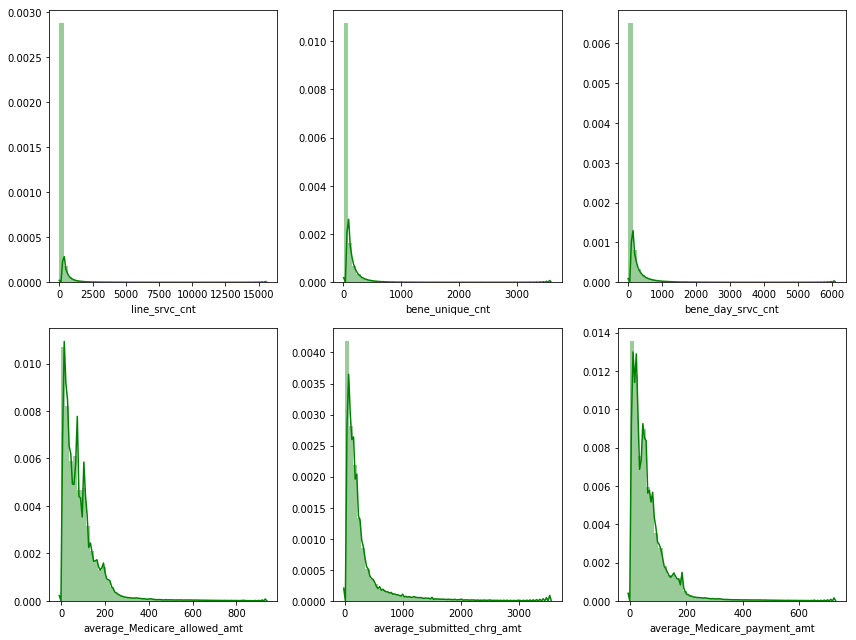

In [52]:
fig, axes = plt.subplots(round(len(df_num.columns) / 3), 3, figsize=(12,9))

for i, ax in enumerate(fig.axes):
    if i < len(df_num.columns):
        sns.distplot(df_num.iloc[:,i], color='g', ax=ax) #hist_kws={'alpha': 0.4})
        
fig.tight_layout()

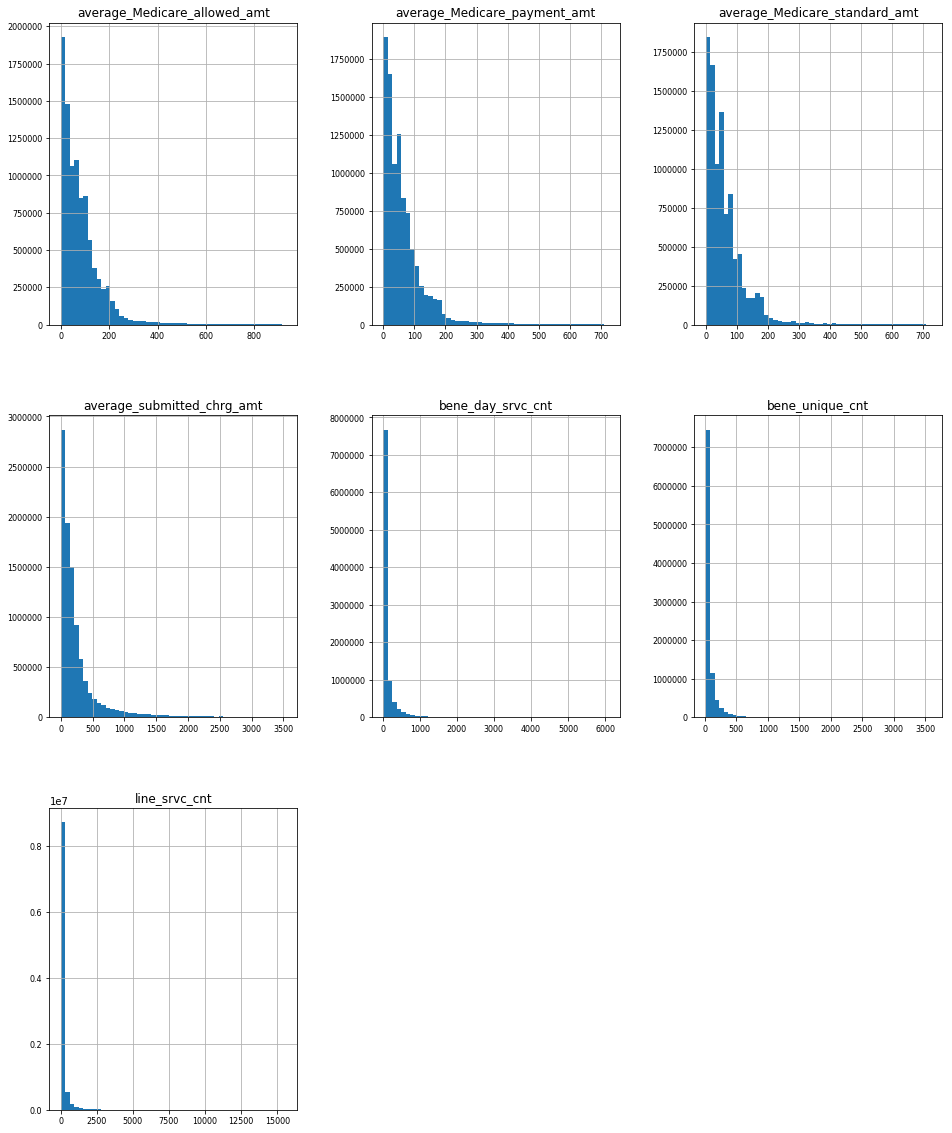

In [62]:
df_num.hist(figsize=(16, 20), bins = 50, xlabelsize=8, ylabelsize=8);

In [56]:
logx = np.log(df_num+1)
logx.describe()

,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt
count,9.689357e+06,9.689357e+06,9.689357e+06,9.689357e+06,9.689357e+06,9.689357e+06,9.689357e+06
mean,4.049679e+00,3.719968e+00,3.969712e+00,3.923733e+00,4.892136e+00,3.667014e+00,3.681859e+00
std,1.209221e+00,9.754828e-01,1.133209e+00,1.142726e+00,1.230041e+00,1.103607e+00,1.099124e+00
min,2.140066e+00,2.484907e+00,2.484907e+00,6.035198e-05,6.035198e-05,0.000000e+00,0.000000e+00
25%,3.091042e+00,2.890372e+00,3.044522e+00,3.223266e+00,4.060443e+00,3.000201e+00,3.039022e+00
50%,3.784190e+00,3.526361e+00,3.737670e+00,4.168833e+00,4.974644e+00,3.857245e+00,3.875346e+00
75%,4.779123e+00,4.343805e+00,4.682131e+00,4.722242e+00,5.666427e+00,4.432918e+00,4.434959e+00
max,9.655859e+00,8.186186e+00,8.715552e+00,6.837272e+00,8.173345e+00,6.585347e+00,6.588716e+00


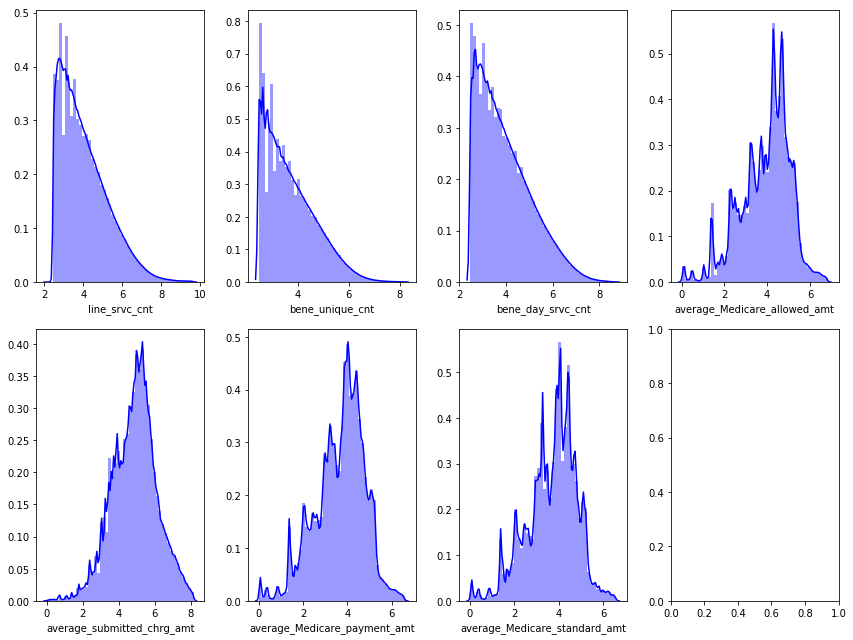

In [57]:
fig, axes = plt.subplots(round(len(df_num.columns) / 3), 4, figsize=(12,9))

for i, ax in enumerate(fig.axes):
    if i < len(df_num.columns):
        sns.distplot(logx.iloc[:,i], color='b', ax=ax) #bins=100, hist_kws={'alpha': 0.4})
        
fig.tight_layout()

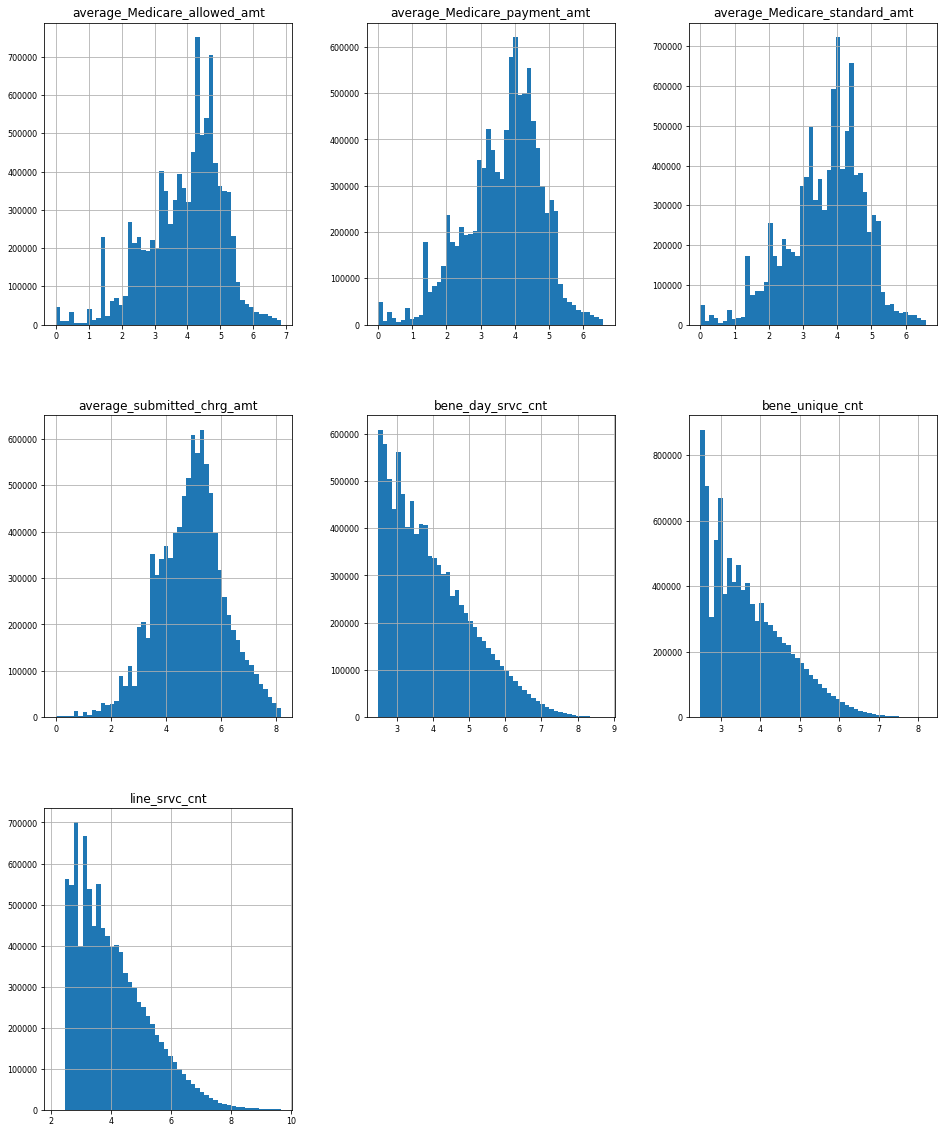

In [63]:
logx.hist(figsize=(16, 20), bins = 50, xlabelsize=8, ylabelsize=8);

## EDA of Non-Numeric Data

count    9.689357e+06
mean     1.499871e+09
std      2.877043e+08
min      1.003000e+09
25%      1.255302e+09
50%      1.497987e+09
75%      1.740680e+09
max      1.993000e+09
Name: npi, dtype: float64


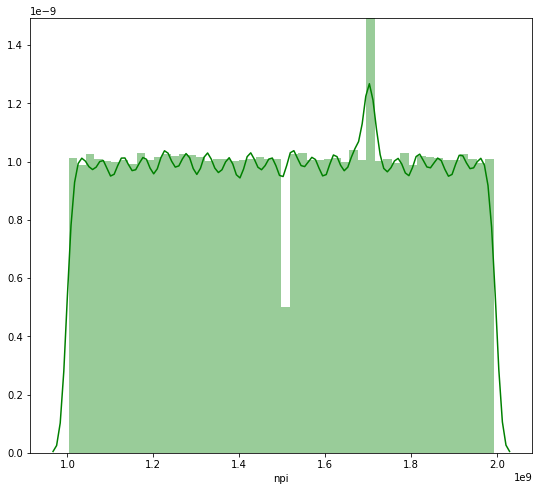

In [64]:
print(df['npi'].describe())
plt.figure(figsize=(9, 8))
sns.distplot(df['npi'], color='g', hist_kws={'alpha': 0.4});

In [65]:
print(df['nppes_credentials'].describe())
#df['nppes_credentials'].apply(pd.Series.value_counts)
#plt.figure(figsize=(9, 8))
#sns.distplot(df['nppes_credentials'], color='g', bins=100);
print(set(df['nppes_credentials']))

count     8997201
unique      15968
top            MD
freq      3184587
Name: nppes_credentials, dtype: object
{nan, 'ACNPC - AG', 'ANP-BC, MSN', 'M.D APMC', 'D.C, A.T.C.', 'L.M.S.W., A.C.S.W.', 'PT MA OCS', 'ADVANCED PRACTICENUR', 'MD, FAAFP, FACEP', 'MCD, CCC-A/S', 'AUD CCC A/SLP', 'DPT, MOT, MTC, CEAS', 'DHSC, MSCPT, MTC', 'MPT, CSCS, OCS, CMPT', 'MD, FACP, AGSF', 'DNP, APRN, ENP, FNP', 'DC LAC CA', 'M.D, MRCS', 'PH.D.,PSY.D.', 'PT DPT', 'DNP, APRN ,AGACNP-BC', 'FLP', 'LISW-S, LCDCIII', 'RN, FNP-C, MSN', 'PA MS', 'MSN, RN, CNS, FNP', 'D.O., F.A.C.O.E.P. D', 'F.N.P. PHD', 'D.C., CCSP', 'MS,APRN, FNP-C', 'MD, MS, FACG', 'MB, BAO, BCH', 'MSPAS-PA-C', 'M.D. F.A.C.G.', 'AGPCNP-BC. BSN-RN', 'MELODY LYND', 'R.N., APN-C.', 'D,IO', 'OTR/L, MS', 'LISW, ACSW', 'M.S., FNP, LIC. AC.', 'P.A.; RPT', 'MHS,PT', 'M.D., PC', 'R.N., F.N.P.-C', 'CRNP-BC', 'MBA/HA, CMC', 'DNP,APN,FNP-BC,MSN', 'M.D., M.M.S.C.', 'MED.,CCC-A', 'PTOMT', 'RN,MSN,ANP-BC', 'M.S. M.D.', 'PT, ATP', 'DNP, APRN, ACNS-BC', 'RN, MSN 

In [68]:
print(df['nppes_provider_state'].describe())
#plt.figure(figsize=(9, 8))
#sns.distplot(df['nppes_provider_state'], color='g', bins=100, hist_kws={'alpha': 0.4});
print(set(df['nppes_provider_state']))

count     9689357
unique         61
top            CA
freq       745862
Name: nppes_provider_state, dtype: object
{'FL', 'AL', 'TN', 'MP', 'IN', 'CA', 'PA', 'WV', 'AP', 'AS', 'SC', 'NY', 'RI', 'UT', 'VI', 'NJ', 'NC', 'IA', 'KS', 'NV', 'DE', 'MI', 'CT', 'WI', 'NH', 'TX', 'AK', 'MS', 'OK', 'LA', 'VT', 'AE', 'MT', 'HI', 'AA', 'WY', 'GU', 'WA', 'OR', 'MN', 'SD', 'VA', 'AZ', 'XX', 'NE', 'OH', 'ME', 'PR', 'ZZ', 'IL', 'GA', 'AR', 'MD', 'MA', 'KY', 'NM', 'ID', 'DC', 'ND', 'MO', 'CO'}


In [69]:
print(df['nppes_provider_country'].describe())
print(set(df['nppes_provider_country']))

count     9689357
unique         25
top            US
freq      9688765
Name: nppes_provider_country, dtype: object
{'LB', 'IN', 'US', 'CA', 'TH', 'NL', 'DE', 'IT', 'KW', 'AE', 'GR', 'AG', 'TT', 'JP', 'PK', 'CN', 'SA', 'MX', 'CR', 'KR', 'IL', 'TR', 'AR', 'GB', 'NO'}


In [70]:
print(df['hcpcs_code'].describe())
#plt.figure(figsize=(9, 8))
#sns.distplot(df['hcpcs_code'], color='g', bins=100, hist_kws={'alpha': 0.4});
#plt.hist(df['hcpcs_code']);
print(set(df['hcpcs_code']))

count     9689357
unique       5652
top         99213
freq       457817
Name: hcpcs_code, dtype: object
{'64530', '83002', '78803', 'Q4014', '83525', '15240', '19328', '27334', '70549', '73590', '33535', '38765', 'Q4022', '76800', '77077', '88363', '74455', '78806', '83026', '64495', '91200', '28126', '92556', 'J2400', '83018', '37222', '99225', '52287', '73721', '81265', '97755', '73503', '81255', '27236', '93530', '92265', '82157', '43213', '35572', '46910', '93454', '44388', '86658', '37193', '10120', '87640', 'G6008', '92081', '92943', '95865', '00522', '73551', '52325', '94450', '96150', '21031', '84157', 'P9041', '80400', '44625', '85306', '73630', 'G6002', '86645', '86140', '29345', 'J2440', '15277', '81383', '31630', '86152', '96103', '73070', 'J1568', '27520', '27033', '36479', '21337', '93623', '52352', '93561', '99305', '80299', '92567', 'J0178', '94642', '15770', '31615', '99233', '97124', '26340', '45505', '46614', 'G0103', '00702', '65930', 'E1399', '77306', '93024', '839

In [32]:
print(df['provider_type'].describe())
print(set(df['provider_type']))

count                  9847443
unique                      94
top       Diagnostic Radiology
freq                   1241400
Name: provider_type, dtype: object
{'Plastic and Reconstructive Surgery', 'Diagnostic Radiology', 'Colorectal Surgery (Proctology)', 'Pain Management', 'Mass Immunizer Roster Biller', 'Allergy/ Immunology', 'Sports Medicine', 'Addiction Medicine', 'Speech Language Pathologist', 'General Practice', 'Psychologist, Clinical', 'Independent Diagnostic Testing Facility (IDTF)', 'Rheumatology', 'Interventional Radiology', 'Clinic or Group Practice', 'Slide Preparation Facility', 'Osteopathic Manipulative Medicine', 'Nurse Practitioner', 'Physician Assistant', 'Emergency Medicine', 'Hematology', 'Hospitalist', 'Dermatology', 'Sleep Medicine', 'Podiatry', 'Interventional Pain Management', 'Certified Registered Nurse Anesthetist (CRNA)', 'Geriatric Medicine', 'Neurosurgery', 'Nephrology', 'Licensed Clinical Social Worker', 'Internal Medicine', 'Chiropractic', 'Neurology', '

## EDA of Categorical Data

Selecting which categorical factors are appropriate to use in clustering.

In [66]:
df_not_num = df.select_dtypes(include = ['O'])
print('There is {} non numerical features including:\n{}'.format(len(df_not_num.columns), df_not_num.columns.tolist()))

There is 18 non numerical features including:
['nppes_provider_last_org_name', 'nppes_provider_first_name', 'nppes_provider_mi', 'nppes_credentials', 'nppes_provider_gender', 'nppes_entity_code', 'nppes_provider_street1', 'nppes_provider_street2', 'nppes_provider_city', 'nppes_provider_zip', 'nppes_provider_state', 'nppes_provider_country', 'provider_type', 'medicare_participation_indicator', 'place_of_service', 'hcpcs_code', 'hcpcs_description', 'hcpcs_drug_indicator']


In [67]:
df_imp_cat = df[['nppes_provider_gender', 'nppes_entity_code', 'nppes_provider_state','nppes_provider_country', 'provider_type', 'medicare_participation_indicator', 'place_of_service', 'hcpcs_drug_indicator']]
print('There is {} non numerical features which are important or not too large in size including:\n{}'.format(len(df_not_num.columns), df_not_num.columns.tolist()))
df_imp_cat.info()
df_imp_cat.describe()

There is 18 non numerical features which are important or not too large in size including:
['nppes_provider_last_org_name', 'nppes_provider_first_name', 'nppes_provider_mi', 'nppes_credentials', 'nppes_provider_gender', 'nppes_entity_code', 'nppes_provider_street1', 'nppes_provider_street2', 'nppes_provider_city', 'nppes_provider_zip', 'nppes_provider_state', 'nppes_provider_country', 'provider_type', 'medicare_participation_indicator', 'place_of_service', 'hcpcs_code', 'hcpcs_description', 'hcpcs_drug_indicator']
<class 'pandas.core.frame.DataFrame'>
Int64Index: 9689357 entries, 1 to 9847443
Data columns (total 8 columns):
nppes_provider_gender               object
nppes_entity_code                   object
nppes_provider_state                object
nppes_provider_country              object
provider_type                       object
medicare_participation_indicator    object
place_of_service                    object
hcpcs_drug_indicator                object
dtypes: object(8)
memory

,nppes_provider_gender,nppes_entity_code,nppes_provider_state,nppes_provider_country,provider_type,medicare_participation_indicator,place_of_service,hcpcs_drug_indicator
count,9295989,9689357,9689357,9689357,9689357,9689357,9689357,9689357
unique,2,2,61,25,94,2,2,2
top,M,I,CA,US,Diagnostic Radiology,Y,O,N
freq,6429582,9295989,745862,9688765,1235785,9686063,6029489,9088521


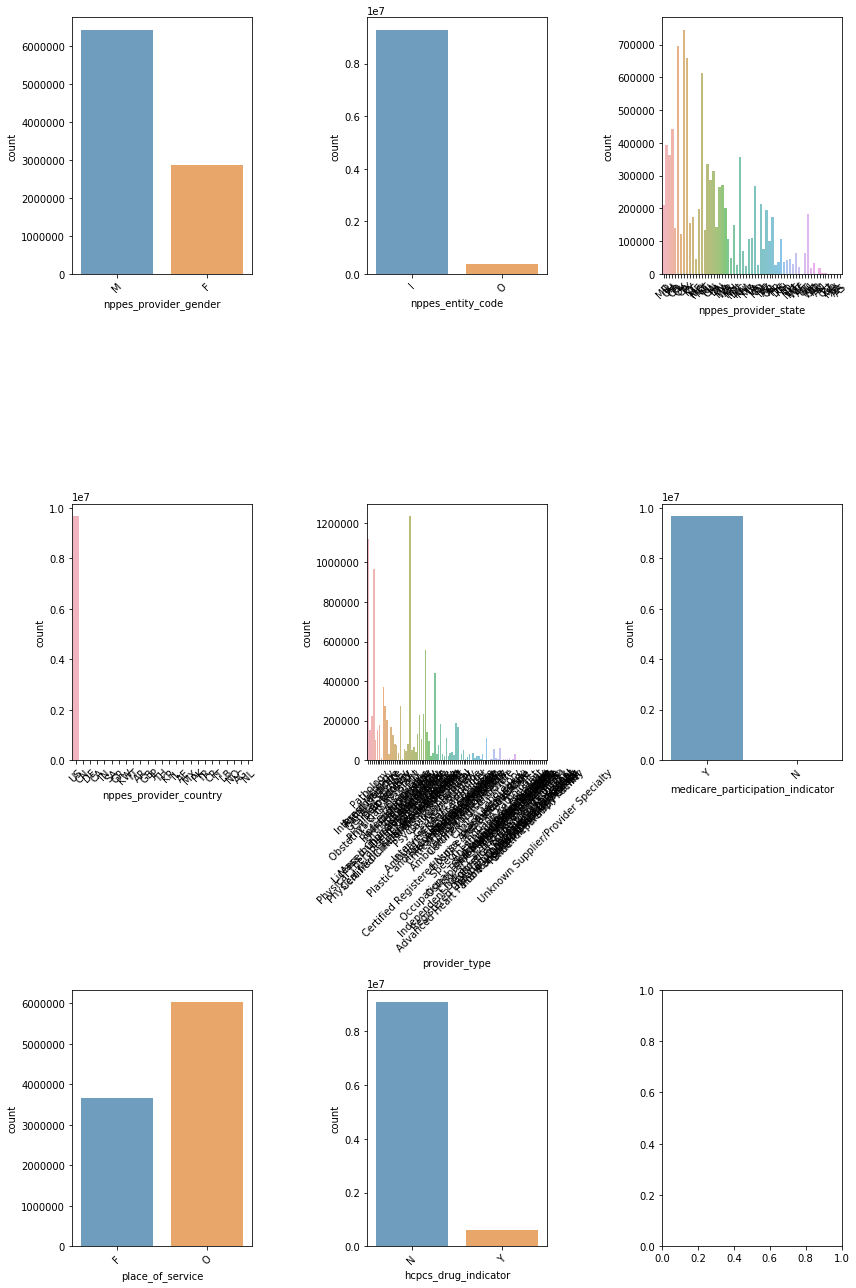

In [71]:
fig, axes = plt.subplots(round(len(df_imp_cat.columns) / 3), 3, figsize=(12,18))

for i, ax in enumerate(fig.axes):
    if i < len(df_imp_cat.columns):
        ax.set_xticklabels(ax.xaxis.get_majorticklabels(), rotation=45)
        sns.countplot(x=df_imp_cat.columns[i], alpha=0.7, data=df_imp_cat, ax=ax)
        
fig.tight_layout()

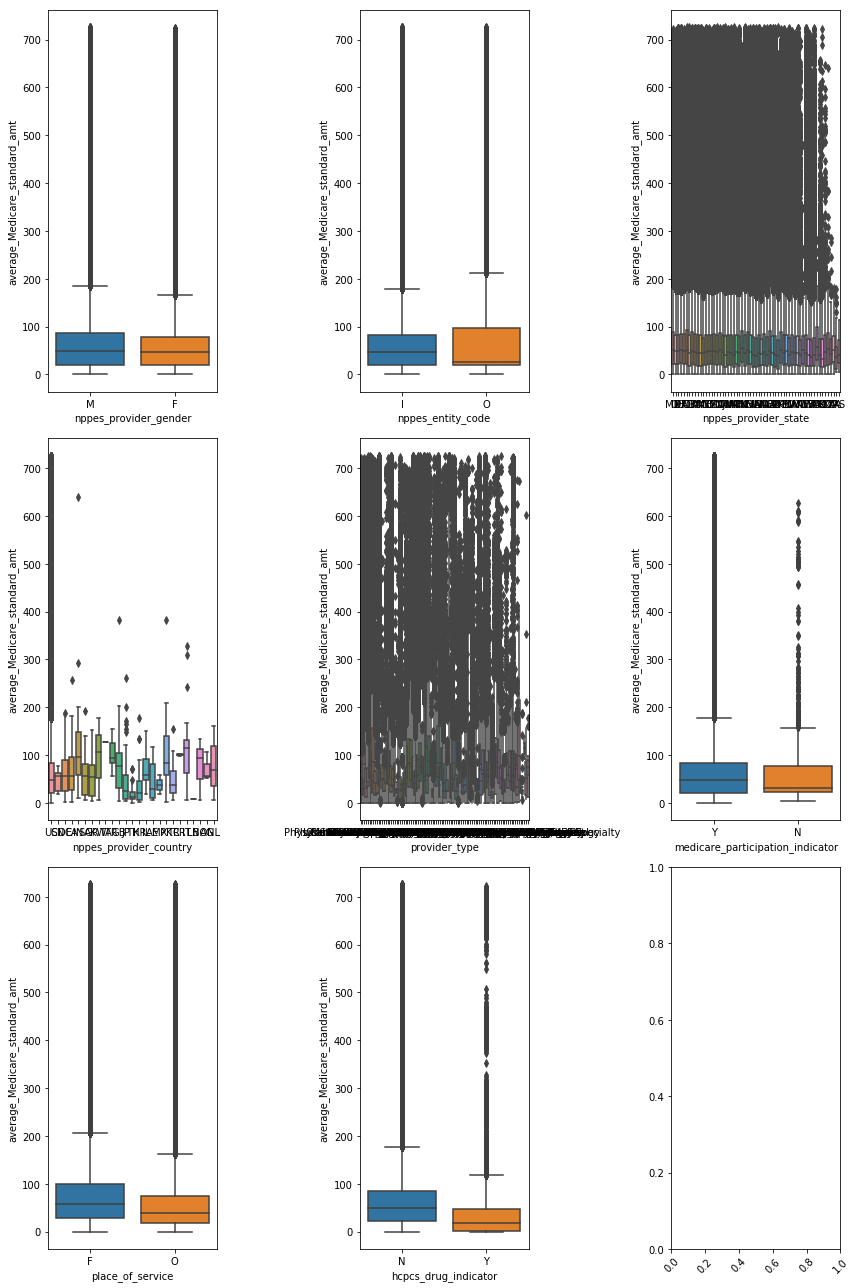

In [72]:
fig, axes = plt.subplots(round(len(df_imp_cat.columns) / 3), 3, figsize=(12,18))

for i, ax in enumerate(fig.axes):
    if i < len(df_imp_cat.columns):
        sns.boxplot(x=df_imp_cat.columns[i], y='average_Medicare_standard_amt', data=df, ax=ax)
        #plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
        plt.xticks(rotation=45)
        
fig.tight_layout()

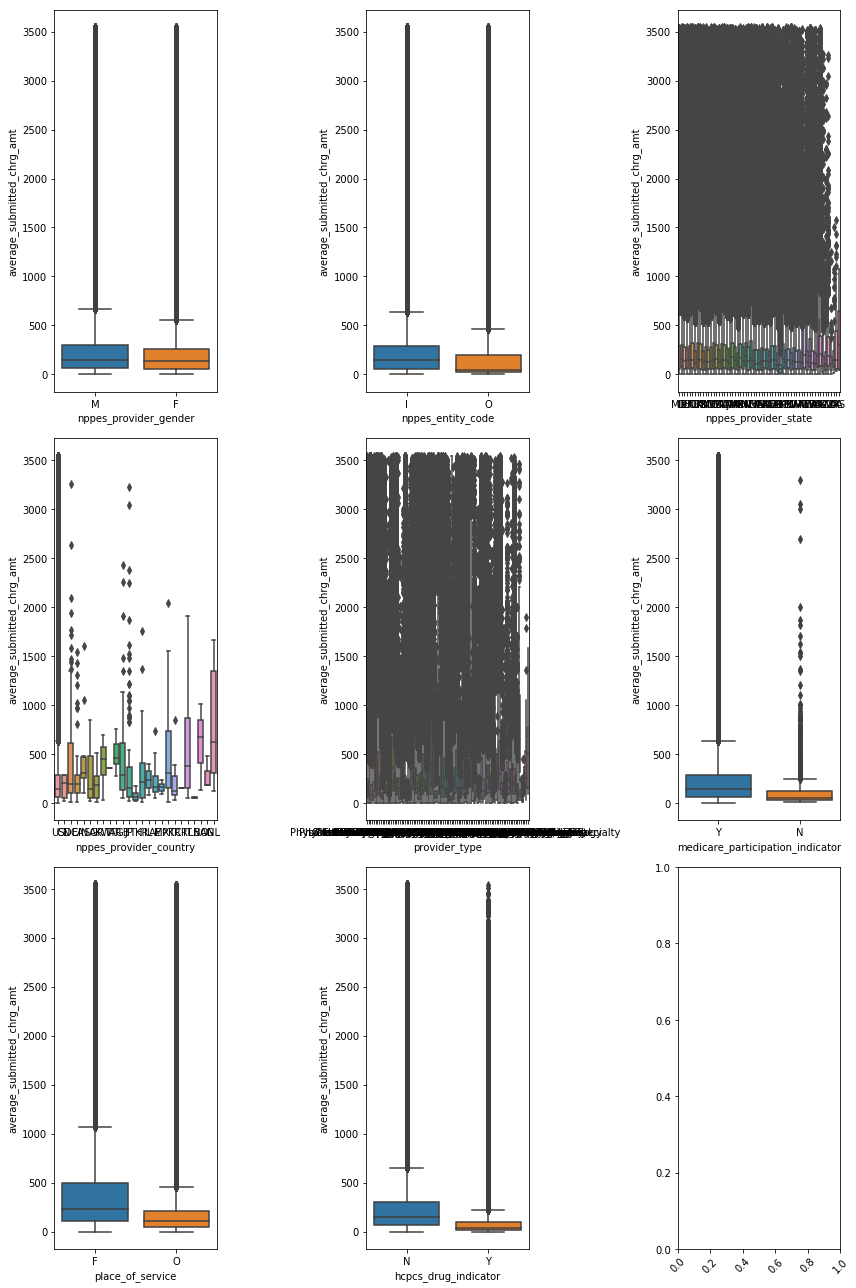

In [73]:
fig, axes = plt.subplots(round(len(df_imp_cat.columns) / 3), 3, figsize=(12,18))

for i, ax in enumerate(fig.axes):
    if i < len(df_imp_cat.columns):
        sns.boxplot(x=df_imp_cat.columns[i], y='average_submitted_chrg_amt', data=df, ax=ax)
        #plt.setp(ax.artists, alpha=.5, linewidth=2, edgecolor="k")
        plt.xticks(rotation=45)
        
fig.tight_layout()

In [90]:
# Creating a dummy variable for gender
pd.get_dummies(df['nppes_provider_gender'],prefix='gender')
df = pd.concat([df,pd.get_dummies(df['nppes_provider_gender'],prefix='gender')],axis=1)

In [91]:
# Creating a dummy variable for the entity code
pd.get_dummies(df['nppes_entity_code'],prefix='entity_code')
df = pd.concat([df,pd.get_dummies(df['nppes_entity_code'],prefix='entity_code')],axis=1)

In [92]:
# Creating a dummy variable for the entity code
pd.get_dummies(df['hcpcs_drug_indicator'],prefix='drug_indicator')
df = pd.concat([df,pd.get_dummies(df['hcpcs_drug_indicator'],prefix='drug_indicator')],axis=1)

In [93]:
# Creating a dummy variable for the participation indicator
pd.get_dummies(df['medicare_participation_indicator'],prefix='participation_indicator')
df = pd.concat([df,pd.get_dummies(df['medicare_participation_indicator'],prefix='participation_indicator')],axis=1)

In [94]:
# Creating a dummy variable for the participation indicator
pd.get_dummies(df['place_of_service'],prefix='place_of_service')
df = pd.concat([df,pd.get_dummies(df['place_of_service'],prefix='place_of_service')],axis=1)

In [95]:
df.shape

(9689357, 36)

In [96]:
df.head(5)

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,gender_F,gender_M,entity_code_I,entity_code_O,drug_indicator_N,drug_indicator_Y,participation_indicator_N,participation_indicator_Y,place_of_service_F,place_of_service_O
1,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,0,1,1,0,1,0,0,1,1,0
2,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,0,1,1,0,1,0,0,1,1,0
3,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,0,1,1,0,1,0,0,1,1,0
4,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,0,1,1,0,1,0,0,1,1,0
5,1003000126,ENKESHAFI,ARDALAN,NaN,M.D.,M,I,900 SETON DR,NaN,CUMBERLAND,...,0,1,1,0,1,0,0,1,1,0


# Dropping categorical variables
df.drop(['nppes_provider_gender'],axis=1, inplace=True)
df.drop(['nppes_entity_code'],axis=1, inplace=True)
df.drop(['hcpcs_drug_indicator'],axis=1, inplace=True)
df.drop(['medicare_participation_indicator'],axis=1, inplace=True)
df.drop(['place_of_service'],axis=1, inplace=True)

## Start Clustering

Group by hcpcs codes 999201 - 99215, which are associated with new and returning outpatient visits. These codes are significant because they represent the most commonly used hcpcs codes. Then, I will cluster on gender, entity code, participation indicator, and drug indicator.

In [249]:
df_clust = []
df_clust = df.loc[df['hcpcs_code'] > '99200']
df_clust = df_clust.loc[df_clust['hcpcs_code'] < '99215']
df_clust.head()

,npi,nppes_provider_last_org_name,nppes_provider_first_name,nppes_provider_mi,nppes_credentials,nppes_provider_gender,nppes_entity_code,nppes_provider_street1,nppes_provider_street2,nppes_provider_city,...,gender_F,gender_M,entity_code_I,entity_code_O,drug_indicator_N,drug_indicator_Y,participation_indicator_N,participation_indicator_Y,place_of_service_F,place_of_service_O
38,1003000142,KHALIL,RASHID,NaN,M.D.,M,I,4126 N HOLLAND SYLVANIA RD,SUITE 220,TOLEDO,...,0,1,1,0,1,0,0,1,0,1
39,1003000142,KHALIL,RASHID,NaN,M.D.,M,I,4126 N HOLLAND SYLVANIA RD,SUITE 220,TOLEDO,...,0,1,1,0,1,0,0,1,0,1
40,1003000142,KHALIL,RASHID,NaN,M.D.,M,I,4126 N HOLLAND SYLVANIA RD,SUITE 220,TOLEDO,...,0,1,1,0,1,0,0,1,0,1
41,1003000142,KHALIL,RASHID,NaN,M.D.,M,I,4126 N HOLLAND SYLVANIA RD,SUITE 220,TOLEDO,...,0,1,1,0,1,0,0,1,1,0
42,1003000142,KHALIL,RASHID,NaN,M.D.,M,I,4126 N HOLLAND SYLVANIA RD,SUITE 220,TOLEDO,...,0,1,1,0,1,0,0,1,0,1


In [250]:
df_clust.describe()

,npi,line_srvc_cnt,bene_unique_cnt,bene_day_srvc_cnt,average_Medicare_allowed_amt,average_submitted_chrg_amt,average_Medicare_payment_amt,average_Medicare_standard_amt,gender_F,gender_M,entity_code_I,entity_code_O,drug_indicator_N,drug_indicator_Y,participation_indicator_N,participation_indicator_Y,place_of_service_F,place_of_service_O
count,1.522841e+06,1.522841e+06,1.522841e+06,1.522841e+06,1.522841e+06,1.522841e+06,1.522841e+06,1.522841e+06,1.522841e+06,1.522841e+06,1.522841e+06,1.522841e+06,1522841.0,1522841.0,1.522841e+06,1.522841e+06,1.522841e+06,1.522841e+06
mean,1.499711e+09,1.555142e+02,9.442795e+01,1.555061e+02,9.285372e+01,1.939398e+02,6.349988e+01,6.495044e+01,3.608453e-01,6.391403e-01,9.999856e-01,1.444668e-05,1.0,0.0,4.425938e-04,9.995574e-01,1.257833e-01,8.742167e-01
std,2.878273e+08,2.629395e+02,1.249273e+02,2.629274e+02,4.155693e+01,1.193832e+02,3.065542e+01,3.028158e+01,4.802459e-01,4.802501e-01,3.800853e-03,3.800853e-03,0.0,0.0,2.103326e-02,2.103326e-02,3.316051e-01,3.316051e-01
min,1.003000e+09,7.500000e+00,1.100000e+01,1.100000e+01,1.000000e-02,1.000000e-02,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,0.0,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.245667e+09,2.500000e+01,2.200000e+01,2.500000e+01,6.770000e+01,1.153241e+02,4.328299e+01,4.595250e+01,0.000000e+00,0.000000e+00,1.000000e+00,0.000000e+00,1.0,0.0,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
50%,1.497964e+09,6.000000e+01,4.900000e+01,6.000000e+01,8.425000e+01,1.661600e+02,5.729762e+01,5.785000e+01,0.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.0,0.0,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
75%,1.740732e+09,1.670000e+02,1.160000e+02,1.670000e+02,1.097500e+02,2.400000e+02,7.666250e+01,7.816931e+01,1.000000e+00,1.000000e+00,1.000000e+00,0.000000e+00,1.0,0.0,0.000000e+00,1.000000e+00,0.000000e+00,1.000000e+00
max,1.993000e+09,6.058000e+03,3.503000e+03,6.057000e+03,2.726200e+02,3.519767e+03,2.614739e+02,1.805492e+02,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.0,0.0,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [251]:
set(df_clust['hcpcs_code'])

{'99201',
 '99202',
 '99203',
 '99204',
 '99205',
 '99211',
 '99212',
 '99213',
 '99214'}

In [252]:
df_clust.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1522841 entries, 38 to 9847439
Data columns (total 36 columns):
npi                                 1522841 non-null int64
nppes_provider_last_org_name        1522813 non-null object
nppes_provider_first_name           1522796 non-null object
nppes_provider_mi                   1131672 non-null object
nppes_credentials                   1475444 non-null object
nppes_provider_gender               1522819 non-null object
nppes_entity_code                   1522841 non-null object
nppes_provider_street1              1522838 non-null object
nppes_provider_street2              678868 non-null object
nppes_provider_city                 1522841 non-null object
nppes_provider_zip                  1522841 non-null object
nppes_provider_state                1522841 non-null object
nppes_provider_country              1522841 non-null object
provider_type                       1522841 non-null object
medicare_participation_indicator    1522841 non-

### Removing all factors except those which will be clustered on

In [253]:
pay_ratio = logx['average_Medicare_allowed_amt']/logx['average_submitted_chrg_amt']

In [254]:
df_clust['pay_ratio'] = pay_ratio
df_clust = df_clust[['bene_day_srvc_cnt', 'pay_ratio']]
df_clust.head()

,bene_day_srvc_cnt,pay_ratio
38,73.0,0.922689
39,36.0,0.928515
40,129.0,0.909629
41,24.0,0.918763
42,330.0,0.917997


In [255]:
df_clust.describe()

,bene_day_srvc_cnt,pay_ratio
count,1.522841e+06,1.522841e+06
mean,1.555061e+02,8.708004e-01
std,2.629274e+02,6.541413e-02
min,1.100000e+01,3.305754e-01
25%,2.500000e+01,8.284448e-01
50%,6.000000e+01,8.715444e-01
75%,1.670000e+02,9.167818e-01
max,6.057000e+03,1.000000e+00


In [256]:
scaler = preprocessing.StandardScaler().fit(df_clust)
dfNorm = scaler.transform(df_clust)

In [257]:
df_clust.head()

,bene_day_srvc_cnt,pay_ratio
38,73.0,0.922689
39,36.0,0.928515
40,129.0,0.909629
41,24.0,0.918763
42,330.0,0.917997


In [259]:
maxClusters = 10
sse = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    sse.append(kmeans.inertia_)

In [260]:
print(sse)

[2046086.8035674335, 1191343.2994612574, 930156.0940673283, 700009.5414845002, 597642.9573105102, 505978.3284033849, 441241.83299241326, 389977.17870939145]


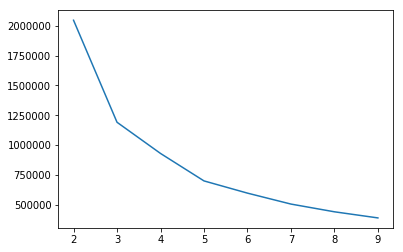

In [261]:
plt.plot(range(2,maxClusters),sse)

In [262]:
silh = []
for nClusters in range(2,maxClusters):
    kmeans = KMeans(n_clusters=nClusters, random_state=0).fit(dfNorm)
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_, sample_size = 10000)
    silh.append(silhouette_avg)

In [263]:
print(silh)

[0.3891494366597966, 0.4365042820736101, 0.3947074652157233, 0.4183688426985159, 0.3845801556194942, 0.4008561751621345, 0.40815579138328, 0.3859856081259142]


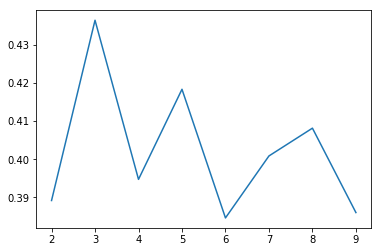

In [264]:
plt.plot(range(2,maxClusters),silh)

In [265]:
kmeans = KMeans(n_clusters=5, random_state=0).fit(dfNorm)

In [266]:
data = pd.concat([df_clust,pd.DataFrame(kmeans.labels_,columns=["Cluster"])],axis=1)

In [268]:
data['Cluster'].value_counts()

1.0    637504
4.0    407739
0.0    316733
2.0    138175
3.0     22690
Name: Cluster, dtype: int64

In [269]:
data.groupby('Cluster').mean()

,bene_day_srvc_cnt,pay_ratio
Cluster,,
0.0,155.497100,0.871352
1.0,156.289901,0.871367
2.0,156.854039,0.870584
3.0,151.249072,0.869626
4.0,155.118484,0.870619


For n_clusters = 3 The average silhouette_score is : 0.4382474825156899
For n_clusters = 5 The average silhouette_score is : 0.4187993846200132


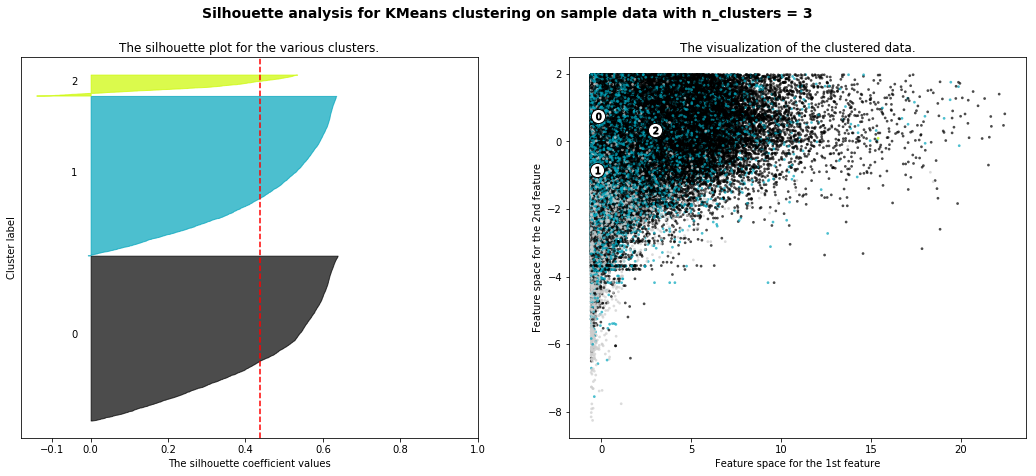

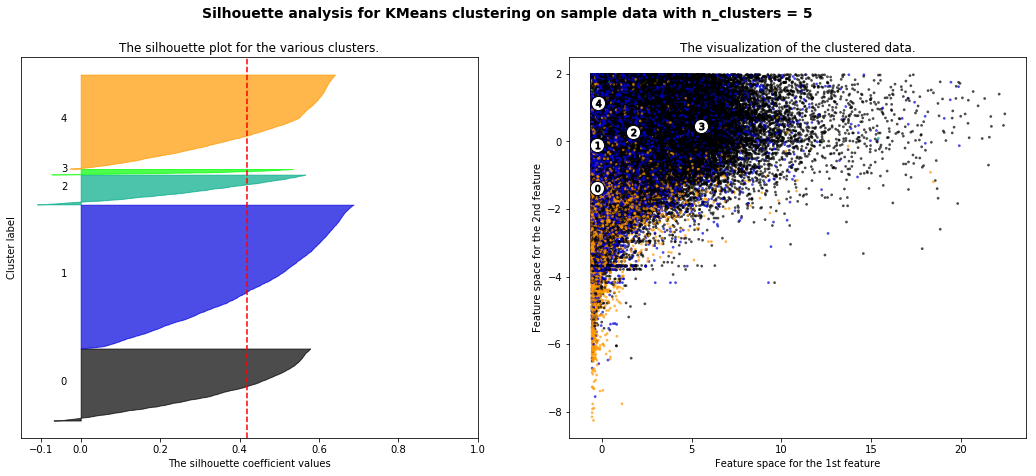

In [272]:
range_n_clusters = [3, 5]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    #ax1.set_xlim([-0.1, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    #ax1.set_ylim([0, len(dfNorm) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value and a random generator
    # seed of 10 for reproducibility.
    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(dfNorm)
    #cluster_labels = clusterer.fit_predict(dfNorm)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(dfNorm, kmeans.labels_, sample_size = 10000)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)
    
    indices = np.random.choice(dfNorm.shape[0], 10000, replace = False)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(dfNorm[indices], kmeans.labels_[indices])

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[kmeans.labels_[indices] == i]
        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(dfNorm[:, 0], dfNorm[:, 1], marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

In [379]:
df_a = []
df_a = df.loc[df['hcpcs_code'] > '99200']
df_a = df_a.loc[df_a['hcpcs_code'] < '99215']
df_a = df_a.reset_index(drop = True)
#print(df_a.iloc[:,10])
#df_a.loc[0, 'nppes_provider_zip']

In [380]:
def region(str):
    str = str[0]
    return(str)

In [381]:
df_a['nppes_provider_zip'] = df_a['nppes_provider_zip'].astype(str)

In [382]:
zip = []
for i in range(len(df_a)):
    i = df_a.iloc[i,10]
    zip.append(region(i))

In [ ]:
zip_array = pd.DataFrame(np.array([zip]).T)
df_a['zip'] = zip_array
#df = pd.concat([df,pd.get_dummies(df['place_of_service'],prefix='place_of_service')],axis=1)
#set(df_a['zip'])
df_a.head()

In [ ]:
finalDF = pd.concat([data,df_a['zip']],axis=1)
finalDF = pd.concat([finalDF,pd.get_dummies(finalDF['zip'],prefix='zip')],axis=1)
#finalDF.drop(finalDF['zip'], inplace = True)
finalDF.head()